<a href="https://colab.research.google.com/github/vishnuk88/exploring/blob/main/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import warnings

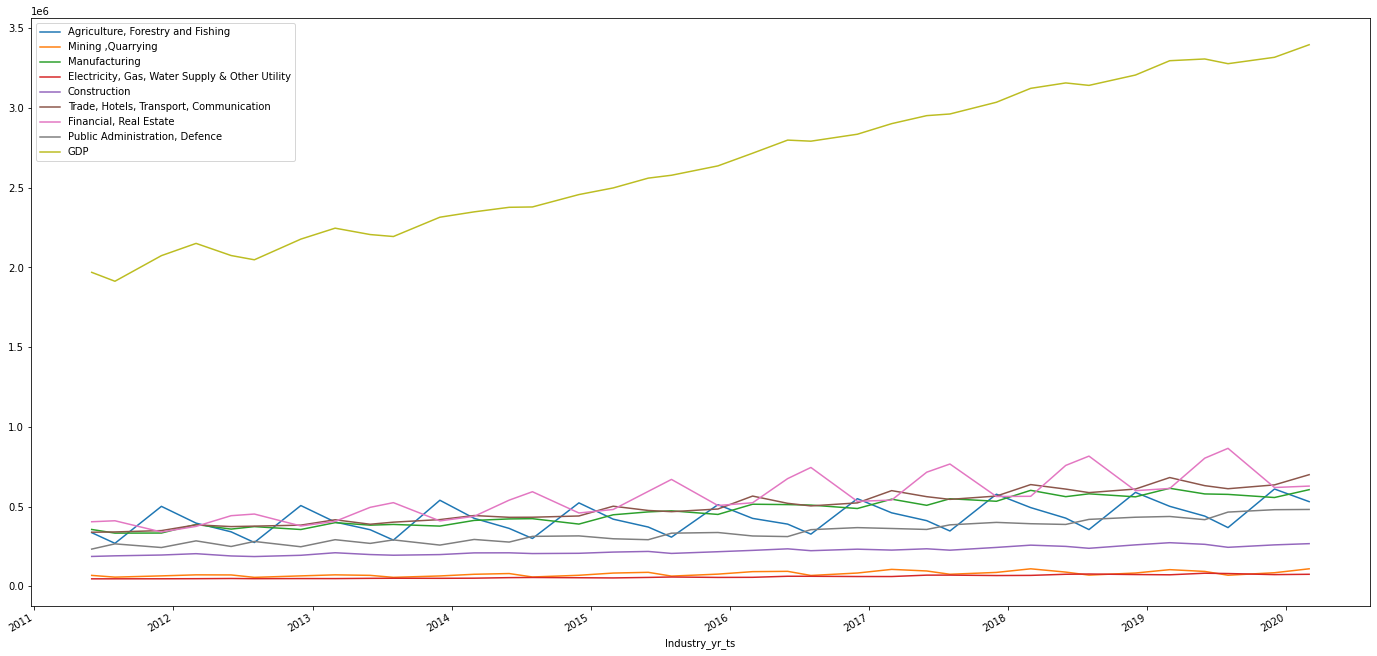

In [26]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/gdp.csv")
df.replace(to_replace ="Q1", 
                 value ="06",inplace=True) 
df.replace(to_replace ="Q2", 
                 value ="08",inplace=True) 
df.replace(to_replace ="Q3", 
                 value ="12",inplace=True) 
df.replace(to_replace ="Q4", 
                 value ="03",inplace=True) 
df['year'] = df['Industry/ Year'].str.split('-').str[0]
df['year'] = df['year'].astype(int)
df['Quarter'] = df['Quarter'].astype(int)
df.loc[df['Quarter'] == 3,"year"] +=1
df['Industry_yr_ts'] = df['year'].map(str)+'-'+df['Quarter'].map(str)+'-'+'1'
df.drop(['Industry/ Year', 'Quarter','year'], axis = 1,inplace=True) 
df['Industry_yr_ts'] = df['Industry_yr_ts'].astype('datetime64[ns]')
df.set_index('Industry_yr_ts',inplace=True)
df.head()
df.plot(figsize=(24, 12))

In [27]:
df.corr()

,"Agriculture, Forestry and Fishing","Mining ,Quarrying",Manufacturing,"Electricity, Gas, Water Supply & Other Utility",Construction,"Trade, Hotels, Transport, Communication","Financial, Real Estate","Public Administration, Defence",GDP
"Agriculture, Forestry and Fishing",1.000000,0.503717,0.345761,0.322304,0.531153,0.470372,-0.099271,0.427193,0.473290
"Mining ,Quarrying",0.503717,1.000000,0.741228,0.582395,0.780191,0.790082,0.325574,0.565981,0.708028
Manufacturing,0.345761,0.741228,1.000000,0.932276,0.942989,0.977525,0.792917,0.916078,0.974422
"Electricity, Gas, Water Supply & Other Utility",0.322304,0.582395,0.932276,1.000000,0.913602,0.914183,0.870963,0.931207,0.962741
Construction,0.531153,0.780191,0.942989,0.913602,1.000000,0.963432,0.664088,0.917033,0.963546
"Trade, Hotels, Transport, Communication",0.470372,0.790082,0.977525,0.914183,0.963432,1.000000,0.709454,0.925333,0.979442
"Financial, Real Estate",-0.099271,0.325574,0.792917,0.870963,0.664088,0.709454,1.000000,0.734693,0.784239
"Public Administration, Defence",0.427193,0.565981,0.916078,0.931207,0.917033,0.925333,0.734693,1.000000,0.951159
GDP,0.473290,0.708028,0.974422,0.962741,0.963546,0.979442,0.784239,0.951159,1.000000


<Figure size 4000x1600 with 0 Axes>

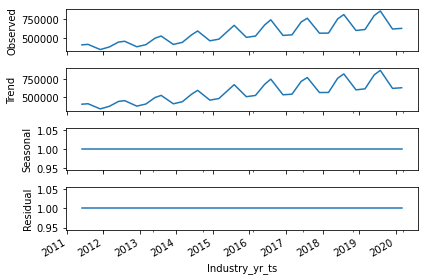

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df["Financial, Real Estate"]
result = seasonal_decompose(series, model='multiplicative',freq=1)
result.plot()
pass

Text(0.5, 1.0, 'Partial Autocorrelation')

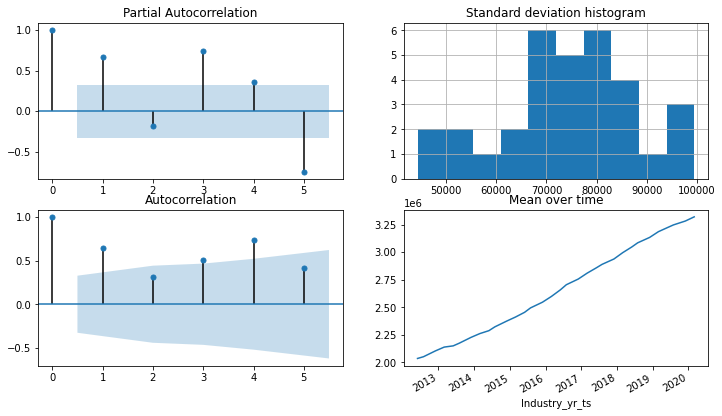

In [29]:
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
pac_ax = plt.subplot2grid(layout, (0,0))
ac_ax = plt.subplot2grid(layout, (1,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,1))

plot_acf(series, lags = 5,ax = ac_ax)
ac_ax.set_title("Autocorrelation")


mm = df.GDP.rolling(5).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df.GDP.rolling(5).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

plot_pacf(series, lags = 5,ax = pac_ax)
pac_ax.set_title("Partial Autocorrelation")

In [30]:

X = df.GDP.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.680836
p-value: 0.441012
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


In [31]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm, tqdm_notebook
# split into train and test sets


In [32]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=185411.549
ARIMA(0, 0, 1) RMSE=136250.137
ARIMA(0, 1, 0) RMSE=144631.348
ARIMA(0, 1, 1) RMSE=113814.902
ARIMA(0, 2, 0) RMSE=217364.986
ARIMA(1, 0, 0) RMSE=138220.329
ARIMA(1, 1, 0) RMSE=145216.507
ARIMA(1, 2, 0) RMSE=222951.071
ARIMA(2, 0, 0) RMSE=141173.557
ARIMA(2, 2, 0) RMSE=105321.924
Best ARIMA(2, 2, 0) RMSE=105321.924


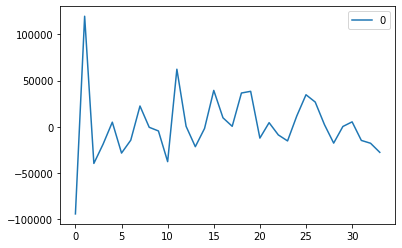

In [33]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()